# Supplemental Material

This document shows the code and results for data processing, model fitting, model selection, and parameter estimation for each model. In addition, all additional statistics (including demographics and descriptives) are reported here along with model diagnostics for the final, reported model.

In [143]:
# Import libraries
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc as pm
import pandas as pd
import os
import aesara
import aesara.tensor as at
import warnings
from platform import python_version

In [144]:
print(f"We used Python [Version {python_version()}] and the Python packages PyMC [Version {pm.__version__}], ArviZ [Version {az.__version__}], NumPy [Version {np.__version__}], pandas [Version {pd.__version__}], Aesara [Version {aesara.__version__}], and seaborn [Version {sns.__version__}] for all data processing, analysis, and presentation.")

We used Python [Version 3.9.5] and the Python packages PyMC [Version 4.0.0b2], ArviZ [Version 0.11.4], NumPy [Version 1.21.5], pandas [Version 1.4.1], Aesara [Version 2.3.8], and seaborn [Version 0.11.2] for all data processing, analysis, and presentation.


# Data Processing 

First we read in the data, removing participant 15 who did not suffer from brain injury but took part in the study regardless. We ensure that the results are reproducible by setting a random seed.

In [145]:
# set options
RANDOM_SEED = 1893
rng = np.random.default_rng(RANDOM_SEED)
az.style.use('arviz-darkgrid') # styling on plots
warnings.filterwarnings('ignore') # suppress warnings

In [146]:
# read data, remove P15, fix data types
dat = pd.read_csv('../data/cleaned-results.csv').query('PID != "P15"').convert_dtypes() 
dat['DJG'] = dat['DJG'].astype(float)

Next, we create the monotonic preedictor from the De Jong Gierveld (DJG) categories present in the data. There are 7 categories ranging from 0-6. Thus, 6 simplex parameters need to be created prior to data modelling. 

In [147]:
# make the simplex parameters for the DJG data
X = np.array(dat.DJG.astype(int))
ncat = len(np.unique(X))
df = ncat -1
con_simo = np.ones(df)

Xmo = np.zeros((len(X), ncat), int)
for ic, i in enumerate(X):
    if i > 0:
        Xmo[ic, :i+1] = np.arange(i + 1)

The Brief Resilience scale (Smith et al., 2013) is scored such that values from 1-2.99 are categorised as low, values from 3-4.30 are categorised as normal, and values of 4.31-5 are categorised as high in resilience. However, with only 1 participant with a score in this high range we collapsed the categories into "low" (-1) and "normal-to-high" (+1) using sum coding. Here, the cutoff is defined as any scores below 3 are "low" and any scores of 3 or more are categorised as normal-to-high.

In [148]:
dat['BRS_cat'] = np.asarray(np.where(dat['BRS'] < 3, -1, 1)) # difference coding

# Data Modelling

First, we defined our maximal model. This takes the form of a Bayesian model estimating monotonic effects of the De Jong Grieveld (DJG) predictor and with the categorical predictor of Brief Resilience Scale (BRS) category. The DJG predictor is estimated using monotonic effects as effects are assumed to have a monotonically increasing relationship with the response, and because this predictor is made up of a limited range of categories which cannot be assumed to be linearly related nor can be assumed to be unrelated categories (Burkner & Charpentier, 2020). Indeed, Burkner and Charpenier note that this model specification is particularly useful with Likert-scale data. The model thus captures and summarises the monotinic effects in terms of two parameters: $\hat{\beta}$ estimaging the magnitude and direction of effect as with typical regression parameter estimates, and $\zeta$ which is a vector estimating the normalised distances between consecutive categories in the predictor. 

Given that the BRS only has 3 categories -- low, medium, and high -- and we have only 1 observation in the high category we collaped this predictor into a simple categorical predictor with the categories low and medium-high. The categorical predictor of BRS was sum-coded (low = -1, medium-high = 1) prior to model fitting. With this model specification, the intercept represents the grand mean collapsed across BRS categories. 

This model used a *Normal*(40, 10) prior on the intercept, a *Normal*(0, 2.5) prior on the DJG monotonic predictors, a *Normal*(0, 10) prior on the BRS predictor, a *Dirichlet*([1 ... 1]) prior on the vector of the simplex monotonic categories, and an *Exponential*(1) prior for the standard deviation term. We compared this model with three other possible models: one removing the effect of DJG, one removing the effect of BRS, and one removing the effects for both DJG and BRS.

We also fitted a model treating the DJG predictor as a continuous variable as is commonly done in psychological research. Given the small sample size this may indeed be more appropriate than treating DJG as a monotonic predictor as fewer parameters need to be estimated. This model used the same priors as the full monotonic model with the exception that no Drichlet prior need be used as simplex monotonic categories were not estimated. We similarly created a reduced version of this model with only DJG as a continuous predictor for full model comparison.

Model comparison was performed using Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV) to establish which of these models makes the best out-of-sample predictions given the data and priors.

In [149]:
a = aesara.shared(np.zeros(1,))

with pm.Model() as full_m_model:
    intercept = pm.Normal('intercept', mu=40., sigma=10.)
    beta_DJG = pm.Normal('beta_DJG', mu=0., sigma=2.5)
    beta_BRS = pm.Normal('beta_BRS', mu=0., sigma=10.)
    sigma = pm.Exponential('sigma', lam=1.)
    simo_t = pm.Dirichlet('simo', a=con_simo)
    simo = at.concatenate([a, simo_t])
    
    mu = intercept + beta_BRS * np.asarray(dat.BRS_cat) + beta_DJG * at.sum(simo[Xmo], axis=1)
    obs = pm.Normal('Y', mu=mu, sigma=sigma, observed=dat['WEMWBS'].values)
    full_m_trace = pm.sample(draws = 3000, tune = 3000, chains = 4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_DJG, beta_BRS, sigma, simo]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 32 seconds.


In [150]:
with pm.Model() as full_c_model:
    intercept = pm.Normal('intercept', mu=40., sigma=10.)
    beta_DJG = pm.Normal('beta_DJG', mu=0., sigma=2.5)
    beta_BRS = pm.Normal('beta_BRS', mu=0., sigma=10.)

    sigma = pm.Exponential('sigma', lam=1.)
    
    mu = intercept + beta_DJG * dat['DJG'].astype(float).values + beta_BRS * dat['BRS_cat'].values
    obs = pm.Normal('Y', mu=mu, sigma=sigma, observed=dat['WEMWBS'].values)
    full_c_trace = pm.sample(draws = 3000, tune = 3000, chains = 4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_DJG, beta_BRS, sigma]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 21 seconds.


In [151]:
with pm.Model() as brs_only_model:
    intercept = pm.Normal('intercept', mu=40., sigma=10.)
    beta_BRS = pm.Normal('beta_BRS', mu=0., sigma=10.)

    sigma = pm.Exponential('sigma', lam=1.)
    
    mu = intercept + beta_BRS * dat['BRS_cat'].values
    obs = pm.Normal('Y', mu=mu, sigma=sigma, observed=dat['WEMWBS'].values)
    brs_only_trace = pm.sample(draws = 3000, tune = 3000, chains = 4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_BRS, sigma]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 17 seconds.


In [152]:
with pm.Model() as djg_m_only_model:
    intercept = pm.Normal('intercept', mu=40., sigma=10.)
    beta_DJG = pm.Normal('beta_DJG', mu=0., sigma=2.5)
    sigma = pm.Exponential('sigma', lam=1.)
    simo_t = pm.Dirichlet('simo', a=con_simo)
    simo = at.concatenate([a, simo_t])
    
    mu = intercept + beta_DJG * at.sum(simo[Xmo], axis=1)
    obs = pm.Normal('Y', mu=mu, sigma=sigma, observed=dat['WEMWBS'].values)
    djg_m_only_trace = pm.sample(draws = 3000, tune = 3000, chains = 4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_DJG, sigma, simo]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 29 seconds.


In [153]:
with pm.Model() as djg_c_only_model:
    intercept = pm.Normal('intercept', mu=40., sigma=10.)
    beta_DJG = pm.Normal('beta_DJG', mu=0., sigma=2.5)

    sigma = pm.Exponential('sigma', lam=1.)
    
    mu = intercept + beta_DJG * dat['DJG'].astype(float).values
    obs = pm.Normal('Y', mu=mu, sigma=sigma, observed=dat['WEMWBS'].values)
    djg_c_only_trace = pm.sample(draws = 3000, tune = 3000, chains = 4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_DJG, sigma]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 18 seconds.


In [154]:
with pm.Model() as intercept_only_model:
    intercept = pm.Normal('intercept', mu=40., sigma=10.)
    sigma = pm.Exponential('sigma', lam=1.)
    
    mu = intercept
    obs = pm.Normal('Y', mu=mu, sigma=sigma, observed=dat['WEMWBS'].values)
    intercept_only_trace = pm.sample(draws = 3000, tune = 3000, chains = 4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, sigma]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 16 seconds.


We results of the LOO-PSIS model comparison are shown below.

In [155]:
comp_loo = az.compare({
    "Full (DJG monotonic)": full_m_trace, 
    "Full (DJG continuous)": full_c_trace,
    "BRS only": brs_only_trace, 
    "DJG (monotonic) only": djg_m_only_trace,
    "DJG (continuous) only": djg_c_only_trace, 
    "Intercept only": intercept_only_trace
    }, 
    ic = 'loo'
)
comp_loo.round(3)

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Full (DJG continuous),0,-88.608,3.849,0.000,0.569,4.510,0.000,False,log
Full (DJG monotonic),1,-88.922,3.483,0.314,0.261,4.705,0.999,False,log
BRS only,2,-89.257,3.421,0.649,0.000,4.746,1.272,False,log
DJG (continuous) only,3,-92.261,2.950,3.653,0.170,3.823,3.561,False,log
DJG (monotonic) only,4,-92.692,2.248,4.084,0.000,4.068,3.827,False,log
Intercept only,5,-93.120,2.197,4.512,0.000,4.131,3.932,False,log


The model comparisons are possibly easier to interpret in graphical form. Here, the best performing model is at the top, with each model following this in order of goodness of fit. The vertical grey line shows the log LOO-PSIS estimate for the best performing model; here, the full model treating DJG as a continuous predictor. Black dots indicate the LOO estimate with the black horizontal bars indicating the standard error around this estimate. The grey triangle indicates the estimate of the difference between each model and the best performing model, with the horizontal grey bars again indicating the standard error of this contrast.

<AxesSubplot:xlabel='Log'>

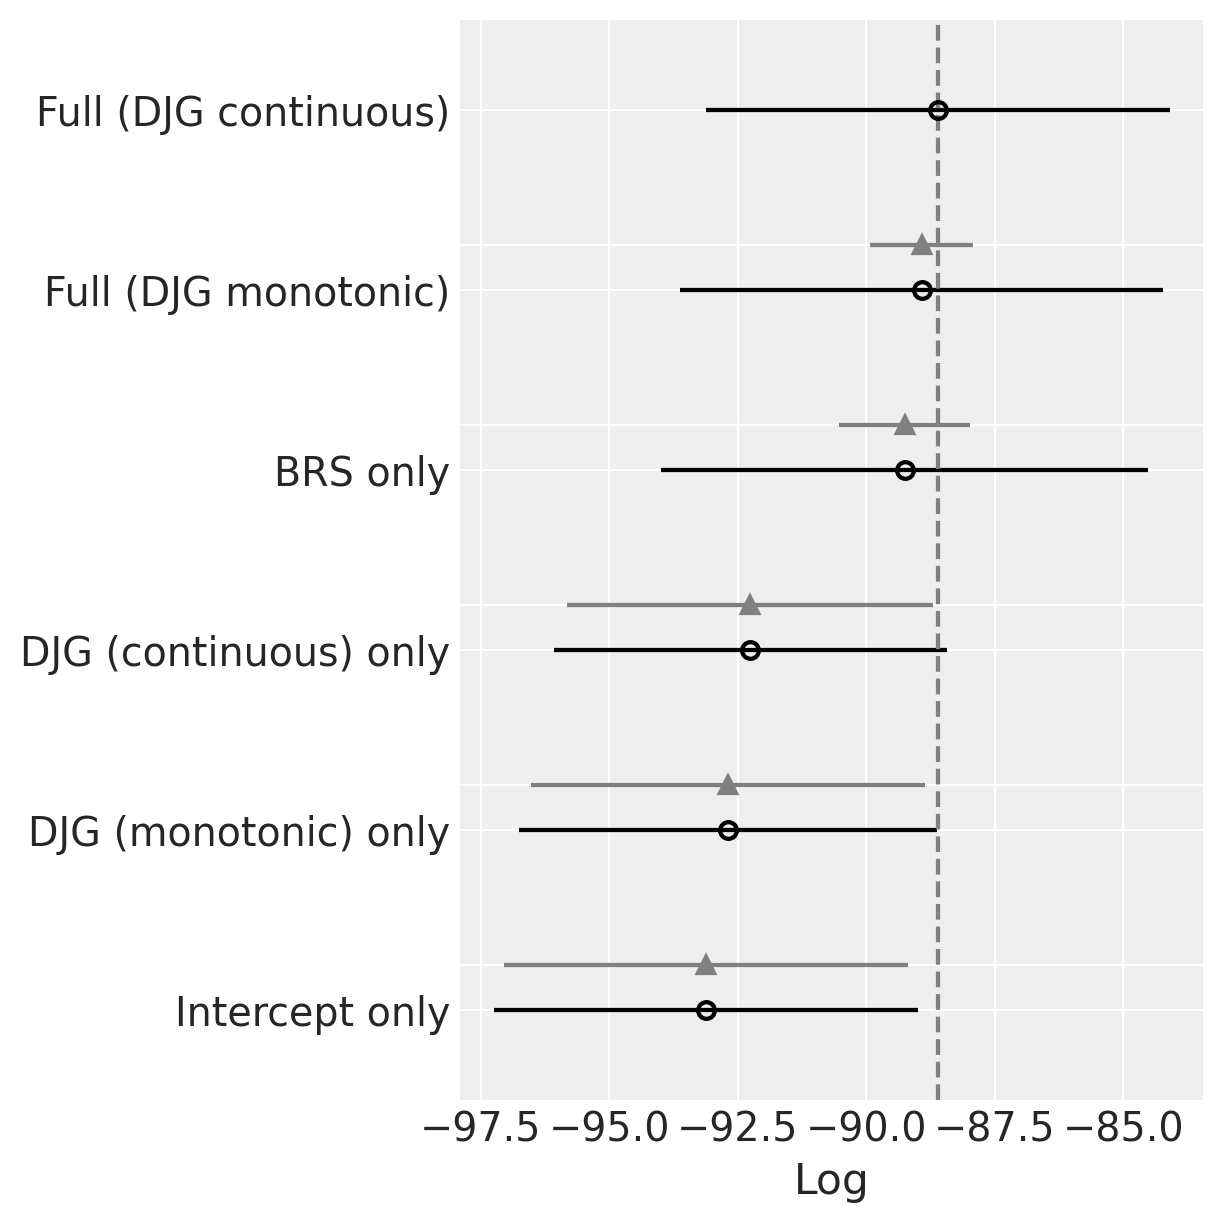

In [156]:
az.plot_compare(comp_loo, insample_dev = False)

This shows that treating DJG as a continuous rather than monotonic predictor provides a minimal advantage in terms of model fit. Most notably, while the DJG-only and intercept-only models perform worse than the full models, there is practically no difference in the fit between the full and BRS only models. Observing the output of the highest ranked model, it is apparent why the specification of the DJG predictor is of little impact and why the BRS only model shows little difference in terms of LOO to both full models: while the DJG predictor is consistently negative in both full models it is not reliably different to zero, with the 90% HDI spanning from negative to postive values. 

In the continuous model there is less uncertainty in the estimate for the effect of DJG on WEMWBS. Thus, across the two full models, while there is evidence for a small, negative effect of DJG on WEMWBS, there is little evidence that this effect is reliably different from zero. Conversely, across both full models and the BRS only model there is consistent evidence that BRS positively contributes to WEMWBS scores, with an average effect of an increase in WEMWBS of at least 14.6 (6.3 $\times$ 2) when going from low to medium-high resilience. 

Notably, in all estimates the intercept is over the threshold of 40 which Taggart et al. (2015) suggest as a cutoff whereby scores at 40 or lower indicate a risk of depression. This indicates that participants are, on average, reasonably healthy in terms of mental wellbeing.

For completeness we show the results of all three models, but report only the top one (DJG continuous) in the report.

In [157]:
trace_summaries = [full_c_trace, full_m_trace, brs_only_trace]

# apply az.summary to each trace and save as data frame
summary_dfs = []
summary_names = ["Full (DJG continuous)", "Full (DJG monotonic)", "BRS only"]
loop_count = 0
for trace in trace_summaries:
    summary_dfs.append(az.summary(trace, hdi_prob=.90).round(3))
    # add each summary names ID to the data frame in the first position
    summary_dfs[loop_count].insert(0, "model", summary_names[loop_count])
    loop_count += 1

# combine the data frames, make the parameter rownames a col, then put model col first
summary_dfs = pd.concat(summary_dfs)
summary_dfs = summary_dfs.rename_axis("parameter").reset_index()
summary_dfs.insert(0, "model", summary_dfs.pop("model"))
summary_dfs


,model,parameter,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,Full (DJG continuous),intercept,45.770,3.114,40.579,50.788,0.040,0.029,5984.0,5940.0,1.0
1,Full (DJG continuous),beta_DJG,-1.282,0.844,-2.709,0.051,0.010,0.007,6817.0,7237.0,1.0
2,Full (DJG continuous),beta_BRS,6.398,1.856,3.461,9.503,0.022,0.015,7168.0,6630.0,1.0
3,Full (DJG continuous),sigma,7.788,0.991,6.201,9.325,0.012,0.008,6904.0,5747.0,1.0
4,Full (DJG monotonic),intercept,42.728,2.184,39.251,46.389,0.026,0.018,7262.0,7736.0,1.0
5,Full (DJG monotonic),beta_DJG,-1.584,2.238,-5.119,2.212,0.025,0.019,7834.0,7734.0,1.0
6,Full (DJG monotonic),beta_BRS,6.761,1.813,3.702,9.630,0.019,0.014,8877.0,7568.0,1.0
7,Full (DJG monotonic),sigma,7.901,1.015,6.295,9.532,0.011,0.008,9151.0,7363.0,1.0
8,Full (DJG monotonic),simo[0],0.164,0.138,0.000,0.361,0.001,0.001,7342.0,4989.0,1.0
9,Full (DJG monotonic),simo[1],0.164,0.139,0.000,0.364,0.001,0.001,7905.0,4555.0,1.0


Again, in the report only the estimates from the best model (DJG continuous) are reported.

Below, we report the descriptive statistics for the WEMWBS scores for those in the low and medium-high BRS categories. In line with the model estimates, this shows that there is an approximately 14 point difference in WEMWBS scores in the low and medium-high BRS categories.

In [158]:
# dat['brs_categorical'] = pd.Categorical(dat.BRS_cat)
# make dat.BRS_cat a categorical variable with labels low and medium
dat['brs_categorical'] = pd.Categorical(dat['BRS_cat'])
dat['brs_categorical'] = dat['brs_categorical'].cat.rename_categories(['low', 'medium-high'])
dat.groupby('brs_categorical').agg({'WEMWBS': ['mean', 'std', 'count']})

WEMWBS                
                      mean       std count
brs_categorical                           
low              34.833333  7.884584     6
medium-high      48.944444  9.276613    18

# Demographics

Below are the age, gender, and time since brain injury demographics for the study.

First, the descriptive statistics for age.

In [159]:
dat.agg({
    'Age': ['mean', 'min', 'max', 'std']
})

,Age
mean,48.750000
min,24.000000
max,68.000000
std,11.085635


Next, the time since brain injury median and interquartile range.

In [160]:
dat['time_since_bi'] = 2021 - dat['BI_Date']
q3, q1 = np.percentile(dat['time_since_bi'], [75 ,25])
iqr = q3 - q1

# make data frame with time sicne bi median
bi_demographics = dat.agg({'time_since_bi': ['median']}).rename(columns={'time_since_bi': 'median_time_since_bi'})
bi_demographics.insert(1, 'iqr', iqr)
bi_demographics


,median_time_since_bi,iqr
median,5.5,14.0


Finally, the counts of genders.

In [161]:
dat.groupby('Gender').agg({'Gender': ['count']})

,Gender
,count
Gender,
F,8
M,16


## Brain Injury and Fitness to Work

Below we show the counts for the severity of brain injury.

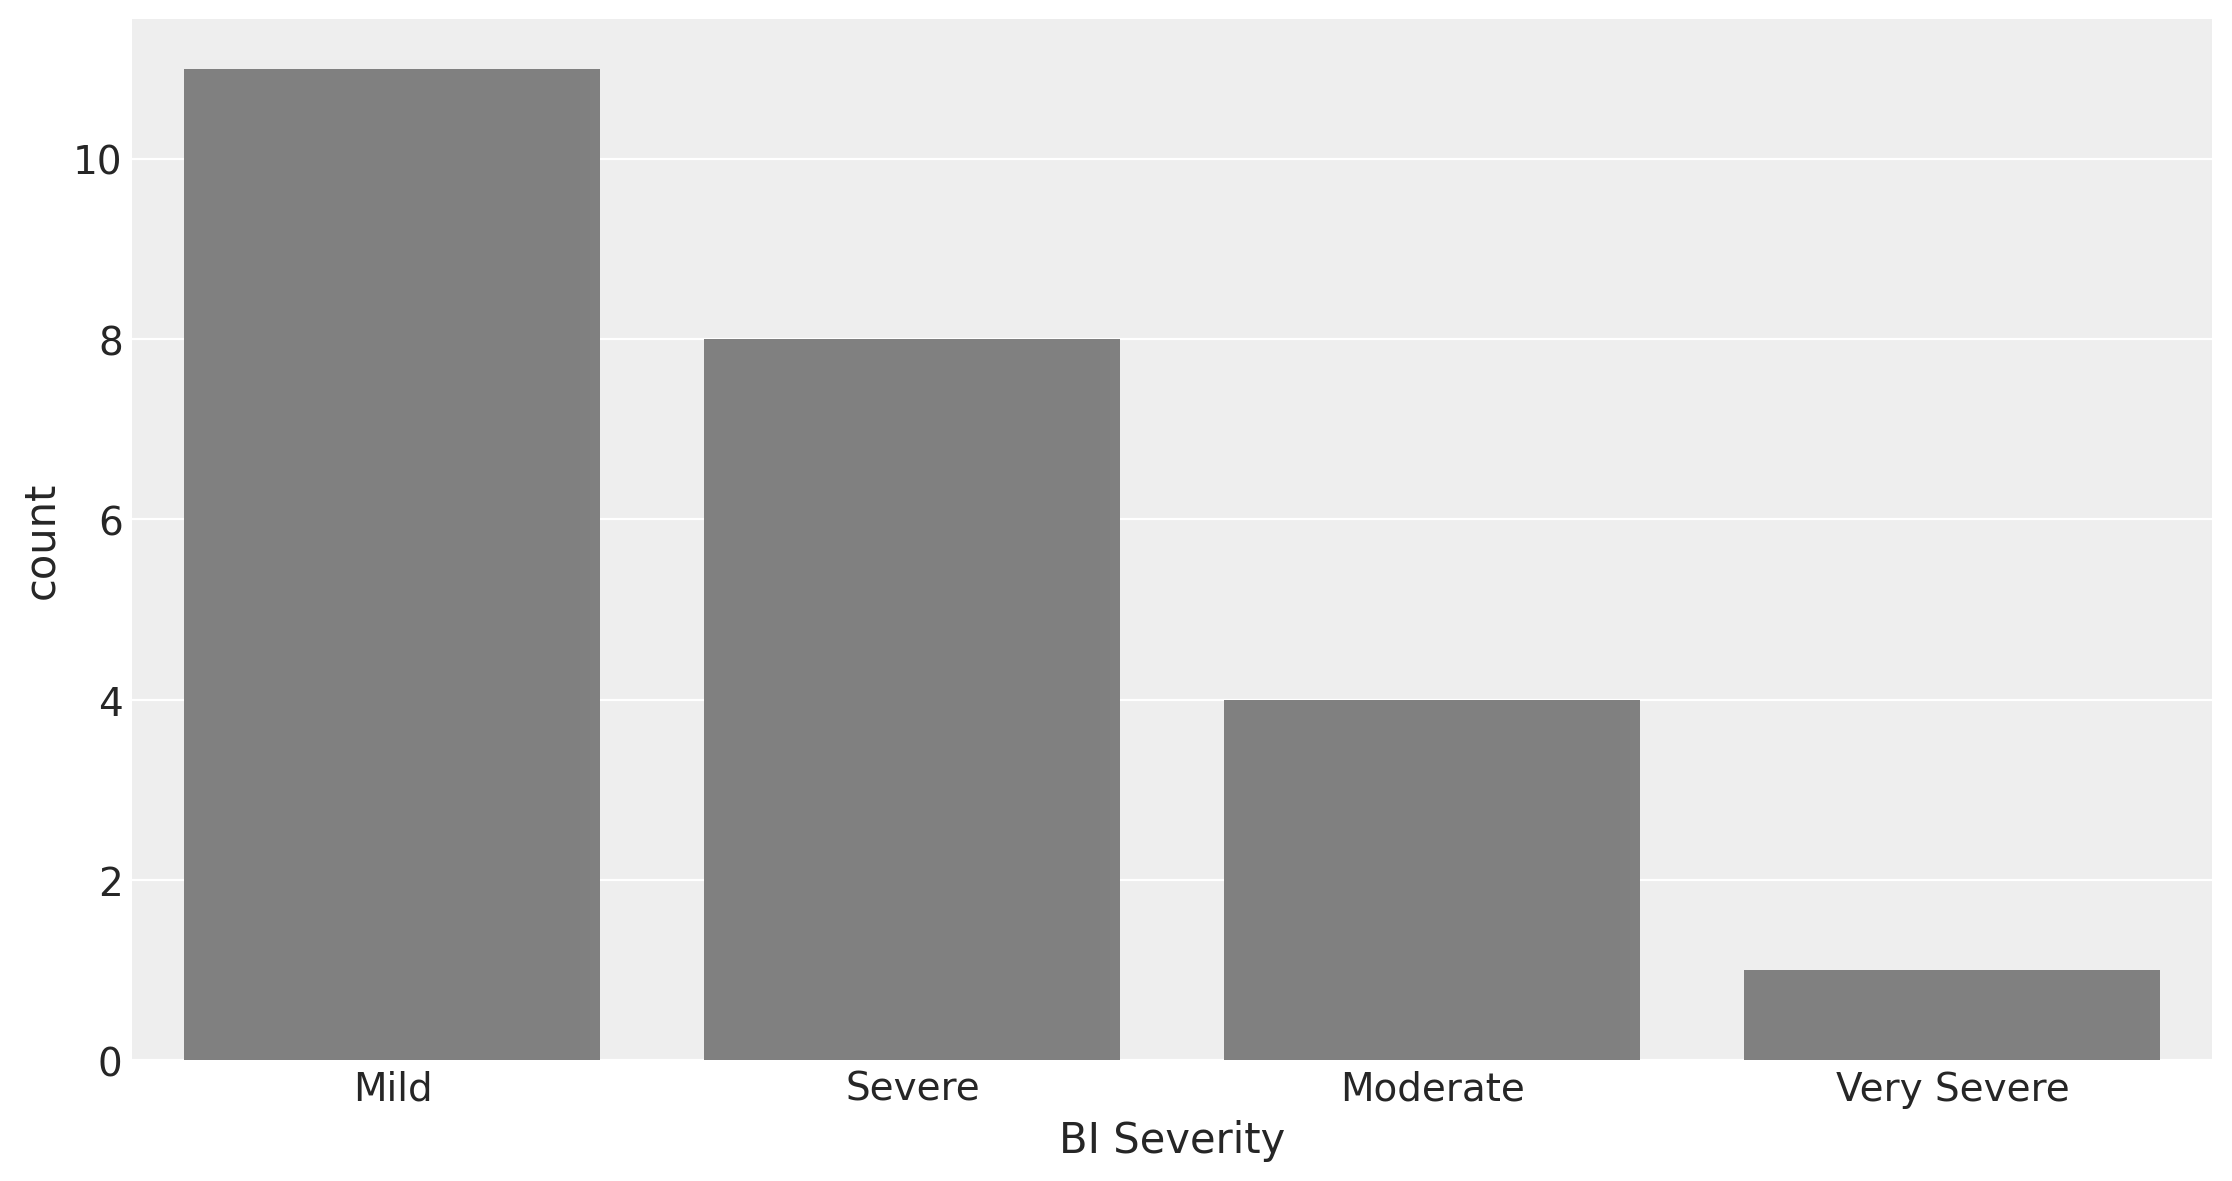

In [162]:
severity = sns.catplot(x = "BI Severity", data = dat, kind = "count", height = 6, aspect = 15/8, color = 'gray')
plt.savefig('../img/severity.png')
severity

Finally, we ask how many participants are fit to work.

In [163]:
print(f"There are {dat['Employment'].str.contains('Medically Retired|Long Term Sick Leave').sum()} participants out of {len(dat)} who are medically retired or on long term sick leave.")

There are 7 participants out of 24 who are medically retired or on long term sick leave.


Below we show the counts for impairments.

In [164]:
dat_impair = pd.concat([dat['PID'], dat.loc[:, 'Vision': 'Pain']], axis=1)
dat_impair_sum = pd.melt(dat_impair, id_vars=['PID'], var_name='Impairment', value_name='Count').query('Count == 1')

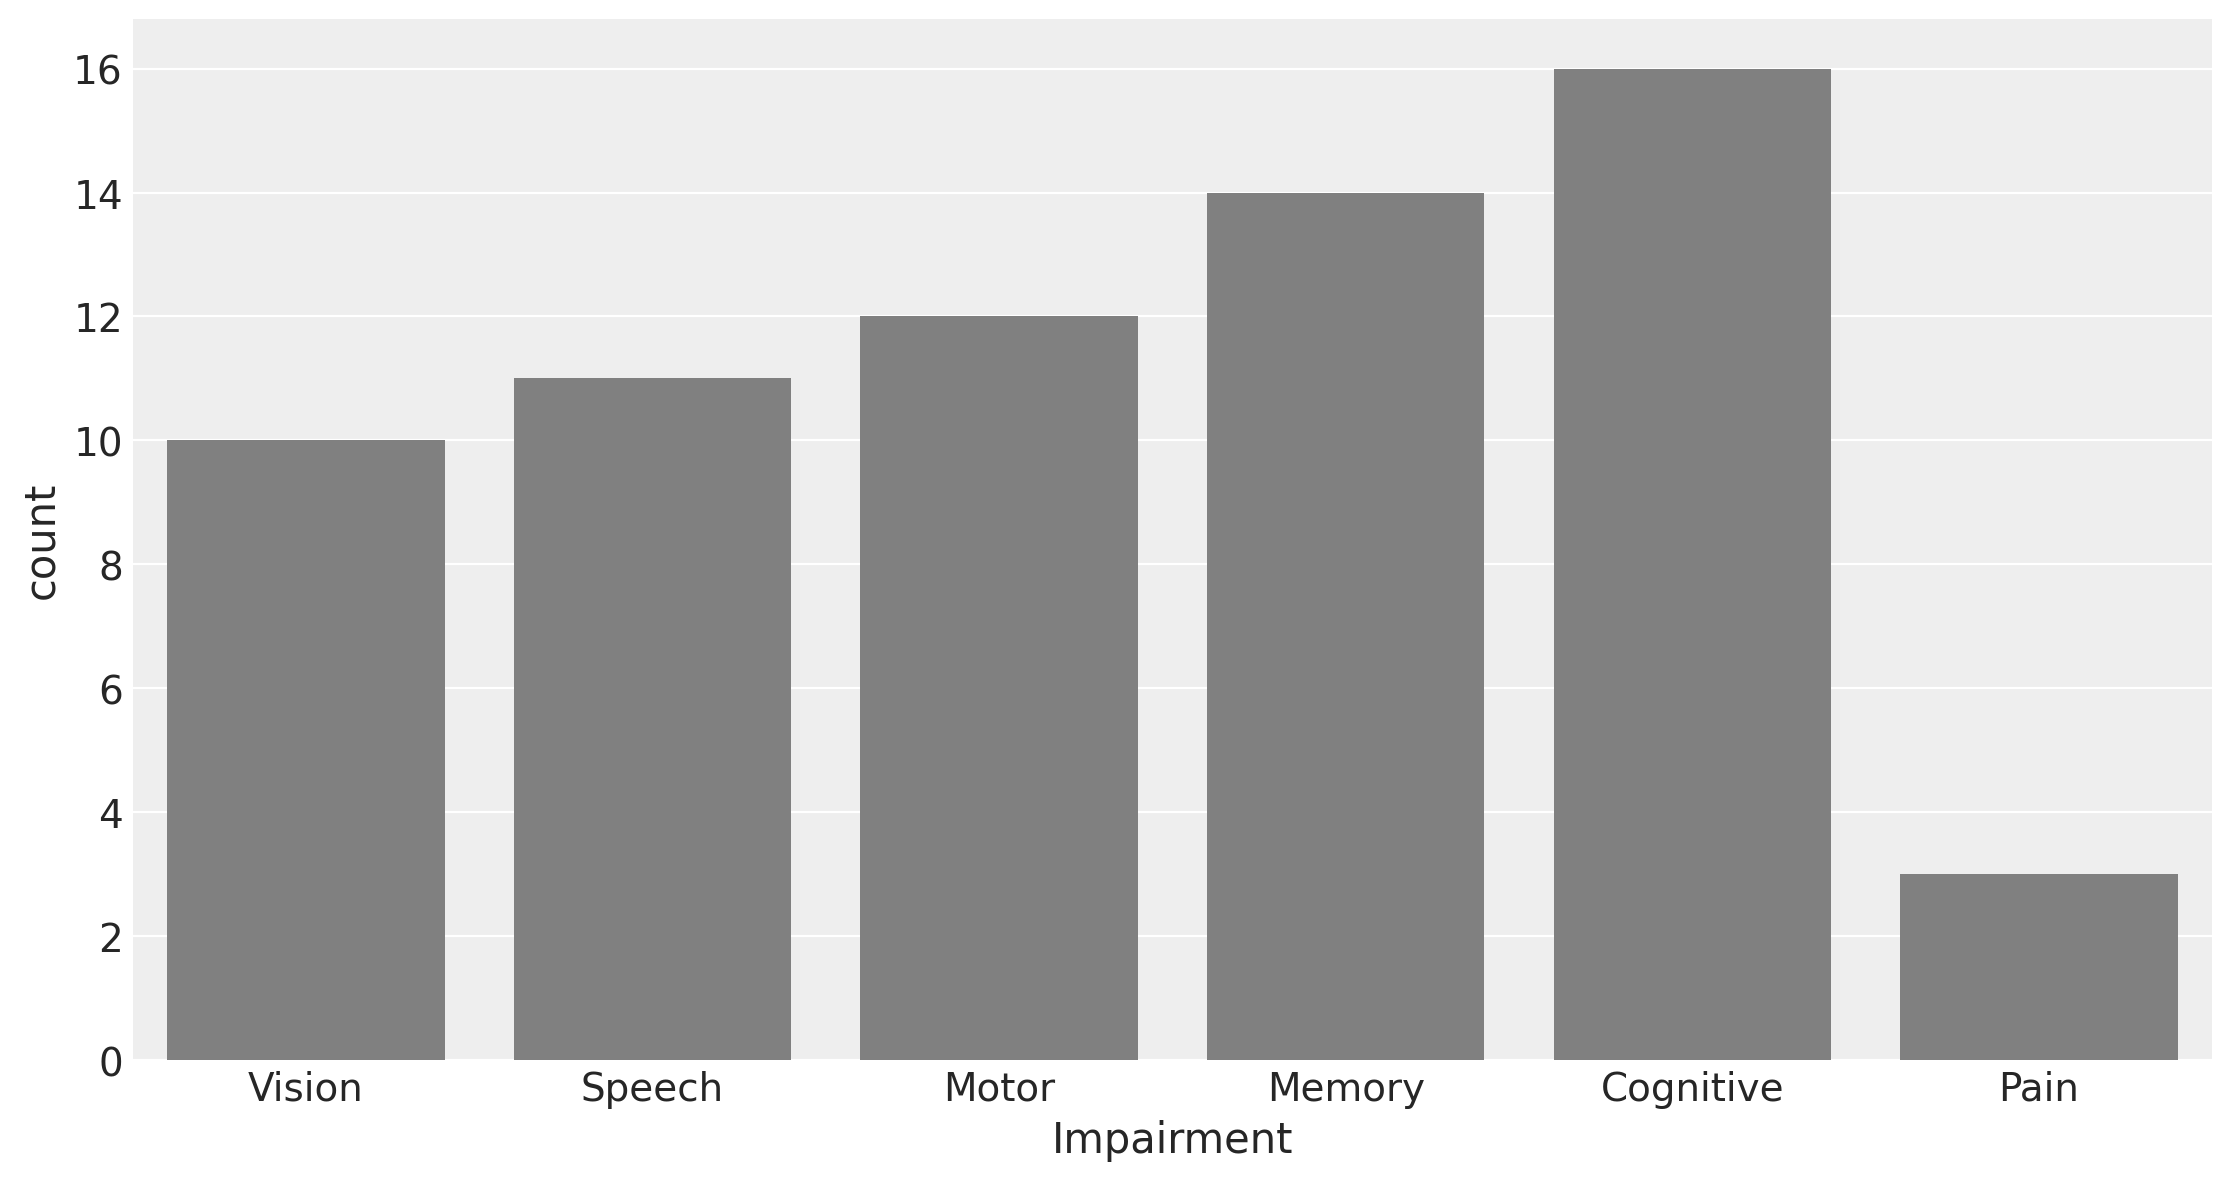

In [165]:
impairments = sns.catplot(x = "Impairment", data = dat_impair_sum, kind = "count", height = 6, aspect = 15/8, color = 'gray')
plt.savefig('../img/impairments.png')
impairments

# Model Diagnostics

Below we show the posterior predictive check for the final, reported model (i.e. the full model with DJG treated as a continuous predictor; full_c_trace). Here the posterior predictive draws and the posterior predictive mean approximate the shape of the observed data, indicating that the model performs well.

<AxesSubplot:xlabel='Y / Y'>

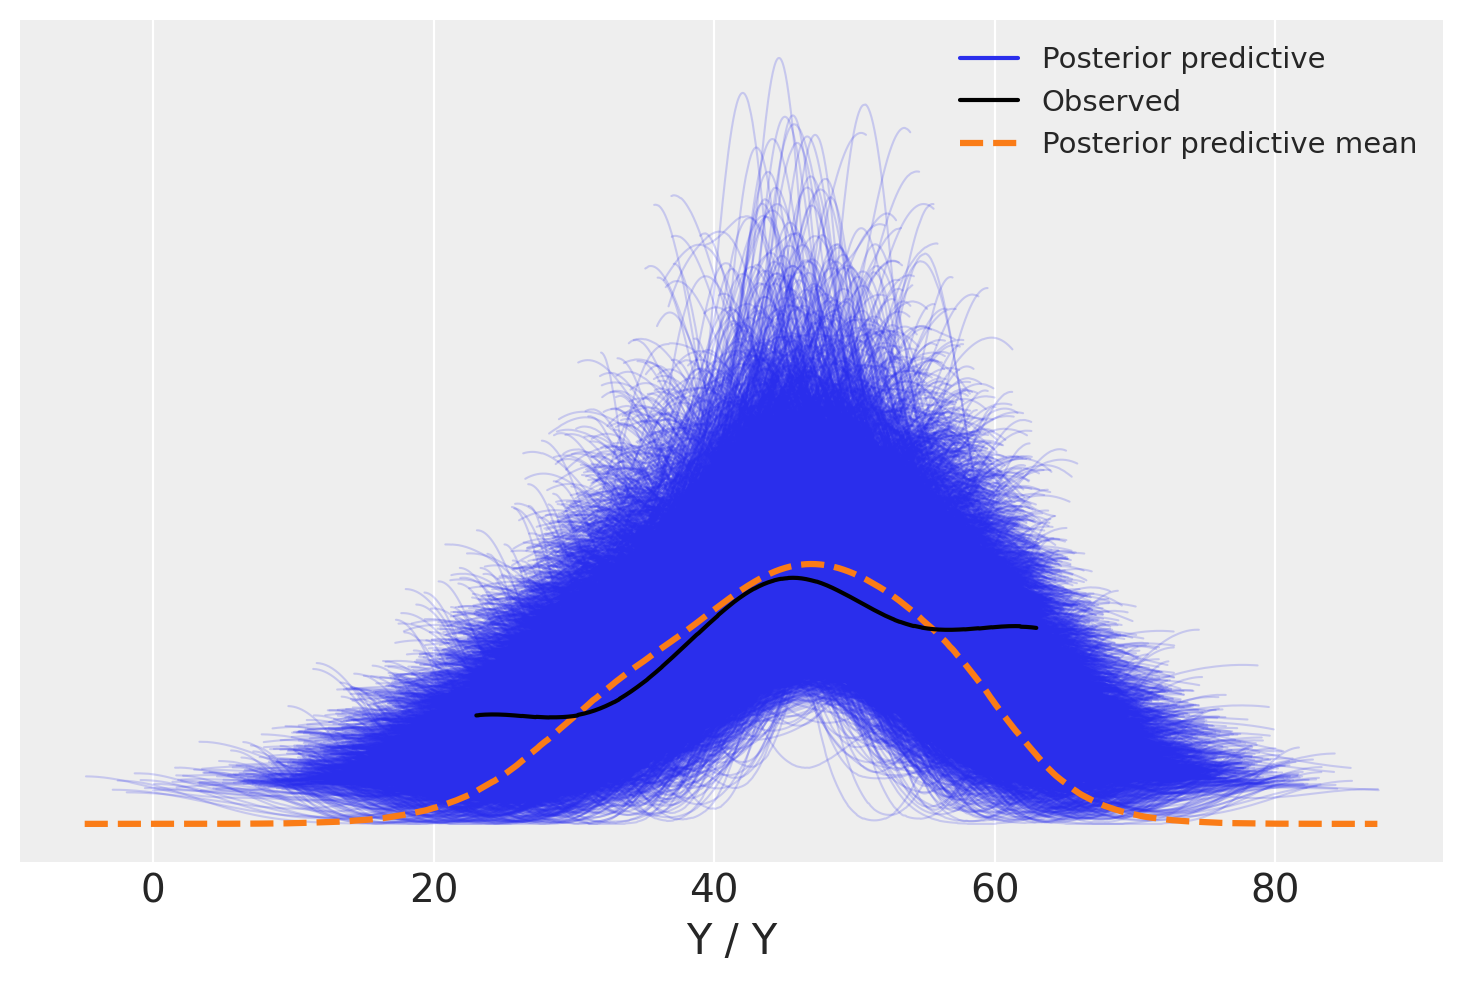

In [166]:
ppc = pm.sample_posterior_predictive(full_c_trace, model=full_c_model)
az.plot_ppc(ppc)

The trace plot below also shows the marginal posterior estimates for the intercept, BRS, and sigma parameters. The trace plots (right panels) show that the chains mixed well.

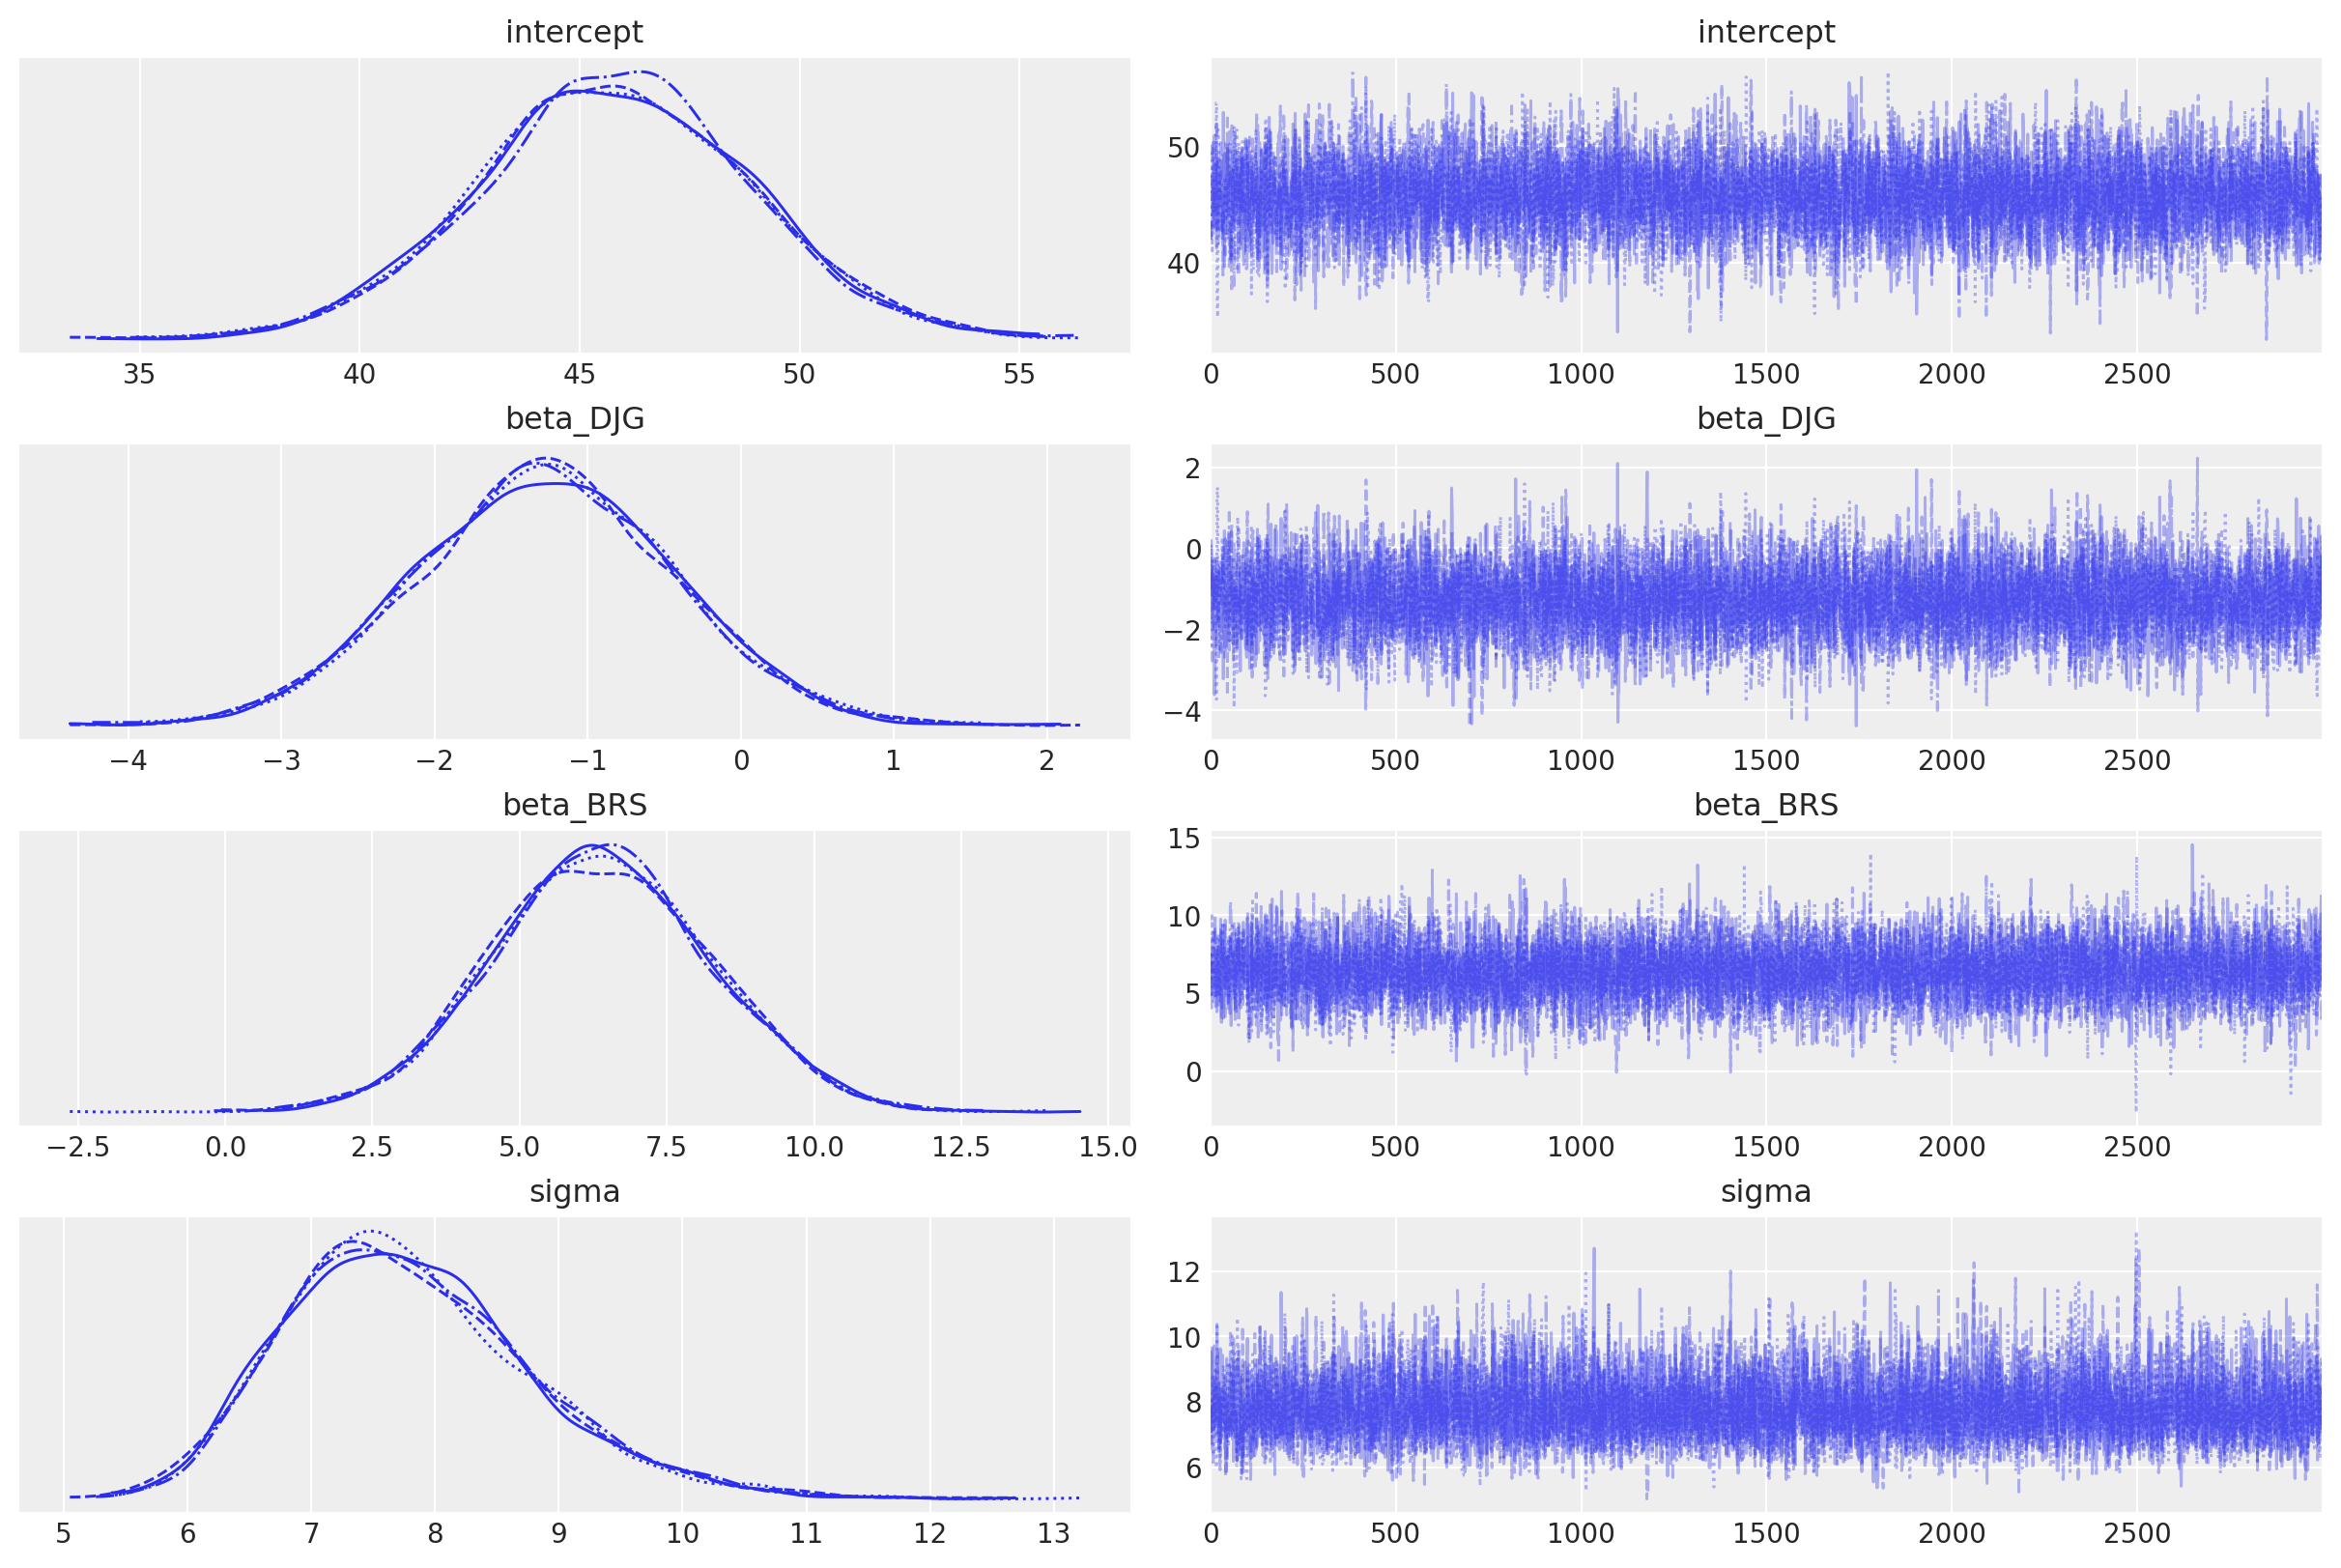

In [167]:
az.plot_trace(full_c_trace);

Details of how and why to fit models using monotonic predictors was obtained from: 

Bürkner, P. C., & Charpentier, E. (2020). [Modelling monotonic effects of ordinal predictors in Bayesian regression models](https://bpspsychub.onlinelibrary.wiley.com/doi/pdf/10.1111/bmsp.12195?casa_token=uc2PZgk3wc4AAAAA:76TREt8u7HFJ-auvEURHDr3yz8kxIgEfn9_1i2SZeagSVXMwPEUj6LutYqOWhOlGDwCOiE0zJIRD4NfESA). *British Journal of Mathematical and Statistical Psychology, 73*(3), 420-451.

Modelling code for the main, monotonic model was adatped from the following sources: 
- https://github.com/junpenglao/Planet_Sakaar_Data_Science/blob/main/Ports/brms_monotonic_compare.ipynb
- https://discourse.pymc.io/t/how-to-build-brms-monotonic-model-with-additional-predictor/4912
- https://austinrochford.com/posts/2018-11-10-monotonic-predictors.html